In [ ]:
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
import torchvision
from skimage.io import imread
from PIL import Image
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


In [ ]:
#Code courtesey:  https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881/6

folder_data = sorted(glob.glob("/content/drive/My Drive/CMPUT328_2020/Week08/TrainingImages/*.jpg"))
folder_mask = sorted(glob.glob("/content/drive/My Drive/CMPUT328_2020/Week08/TrainingLabels/*.jpg"))

# split these path using a certain percentage
len_data = len(folder_data)
print(len_data)
#train_size = 0.6

train_image_paths = folder_data #[:int(len_data*train_size)]
#test_image_paths = folder_data[int(len_data*train_size):]

train_mask_paths = folder_mask #[:int(len_data*train_size)]
#test_mask_paths = folder_mask[int(len_data*train_size):]

class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    def __getitem__(self, index):

        image = imread(self.image_paths[index])
        mask = torch.tensor(imread(self.target_paths[index])>100.0).long()
        t_image = self.transforms_image(image)
        return t_image, mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)

train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

#test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)


38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32]) torch.Size([10, 32, 32])


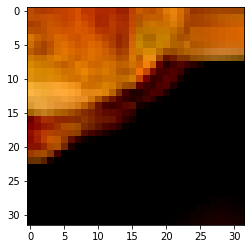

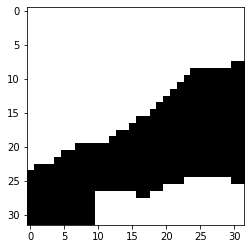

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])


In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape,example_targets.shape)

plt.imshow(example_data[0].permute(1,2,0).data)
plt.show()
plt.imshow(example_targets[0].squeeze().data,cmap="gray")
plt.show()

print(example_targets[0].squeeze().data[:])

In [ ]:
# Gaussian filter: https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/2
kernel_size = 7
sigma = 2.0

# Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
x_cord = torch.arange(kernel_size)
x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
y_grid = x_grid.t()
xy_grid = torch.stack([x_grid, y_grid], dim=-1)

mean = (kernel_size - 1)/2.
variance = sigma**2.

# Calculate the 2-dimensional gaussian kernel which is
# the product of two gaussian distributions for two different
# variables (in this case called x and y)
gaussian_kernel = (1./(2.*math.pi*variance)) *\
                  torch.exp(
                      -torch.sum((xy_grid - mean)**2., dim=-1) /\
                      (2*variance)
                  )
# Make sure sum of values in gaussian kernel equals 1.
gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

# Reshape to 2d depthwise convolutional weight
gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
gaussian_kernel = gaussian_kernel.repeat(2, 1, 1, 1)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=5)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=5)
        self.conv3 = nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=3, stride=3)
        self.conv4 = nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=3, stride=2,output_padding=1)
        # Gaussian blurring layer - this will be applied to every plane in the feature map
        self.gaussian_filter = nn.Conv2d(in_channels=2, out_channels=2,kernel_size=3, groups=2, bias=False, padding=3)
        self.gaussian_filter.weight.data = gaussian_kernel
        self.gaussian_filter.weight.requires_grad = False

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x1 = F.max_pool2d(x, kernel_size=2, stride=2)
        x2 = F.relu(self.conv2(x1))
        x3 = F.max_pool2d(x2, kernel_size=2, stride=2)
        x4 = F.relu(self.conv3(x3))

        # a skip connection that works with any input size - interpolate to compatible size
        yv, xv = torch.meshgrid([torch.arange(0,x4.shape[2]).float().to(device), torch.arange(0,x4.shape[3]).float().to(device)])
        # map coordinates to [-1,1]x[-1,1] so that grid_sample works properly
        yv = 2.0*yv/(x4.shape[2]-1) - 1.0
        xv = 2.0*xv/(x4.shape[3]-1) - 1.0
        grid = torch.stack([xv,yv],2).unsqueeze(0).repeat([x4.shape[0],1,1,1])
        x4 += F.grid_sample(x1,grid,align_corners=False)
        # end of skip connection

        x5 = self.conv4(x4)
        x6 = self.gaussian_filter(x5).squeeze()
        return F.log_softmax(x6,dim=1)

In [ ]:
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=1e-3)

for itr in range(1000):
  loss_val=0.0
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.squeeze().to(device)
    optimizer.zero_grad()
    output = network(data)
    #print(output.shape,target.shape)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    loss_val += loss.item()
  if itr%100==0:
    print(loss_val)

2.678985059261322
0.2808988504111767
0.20509136840701103
0.17354604974389076
0.15981221571564674
0.1432787198573351
0.1351762991398573
0.12524122837930918
0.12206850945949554
0.1202019453048706


In [ ]:

# Try trained model on flower image
flower = imread("/content/drive/My Drive/CMPUT328_2020/Week08/flower.jpg")

binary_seg = network(torch.tensor(2.0*flower/np.amax(flower)-1.0,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)).permute(1,2,0)

print(binary_seg.shape)

torch.Size([620, 944, 2])


flower image shape (427, 640, 3)
segmented image shape torch.Size([620, 944, 2])


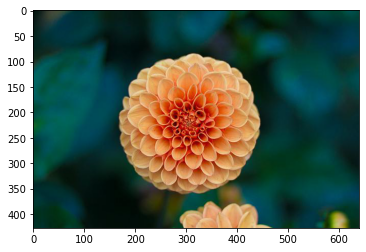

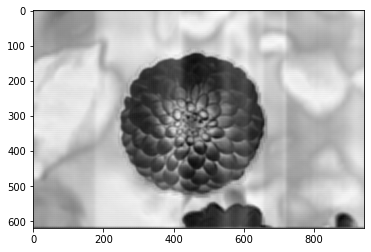

In [ ]:

print("flower image shape",flower.shape)
print("segmented image shape",binary_seg.shape)
plt.imshow(flower)
plt.show()
plt.imshow(binary_seg[:,:,0].cpu().data,cmap="gray")
plt.show()